In [196]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

import seaborn as sns

In [197]:
sns.set_theme()

In [198]:
model_pth = '/home/giacomo/Desktop/results_cl_ssl/OCL/imagenet100/simsiam/iid_replay_simsiam_imagenet100_05-28_00-24'
model_name = 'IID SimSiam Experience Replay ImageNet100'
activations_pth = os.path.join(model_pth, 'activations')

In [199]:
def get_svd(activations):
    reprs = activations.reshape(-1, activations.shape[-1])

    norms = torch.linalg.norm(reprs, dim=1)
    normed_reprs = reprs / (1e-6 + norms.unsqueeze(1))
    svd = torch.svd(normed_reprs).S
    return svd

# Task agnostic collapse

Get test activations and svd

In [200]:
test_file_list = [f for f in os.listdir(activations_pth) if f.startswith("test_activations") and f.endswith(".npy")]

# Load and concatenate the arrays
arrays = []
for file in test_file_list:
    array = np.load(os.path.join(activations_pth, file))
    arrays.append(array)

# Concatenate all activations along the first dimension
all_test_activations = torch.from_numpy(np.concatenate(arrays, axis=0))
print(all_test_activations.shape)

torch.Size([5000, 512])


In [201]:
test_svd = get_svd(all_test_activations)
print(test_svd.shape)

torch.Size([512])


Get val activations

In [202]:
val_file_list = [f for f in os.listdir(activations_pth) if f.startswith("val_activations") and f.endswith(".npy")]

# Load and concatenate the arrays
arrays = []
for file in val_file_list:
    array = np.load(os.path.join(activations_pth, file))
    arrays.append(array)

# Concatenate all activations along the first dimension
all_val_activations = torch.from_numpy(np.concatenate(arrays, axis=0))
print(all_val_activations.shape)

torch.Size([12895, 512])


In [203]:
val_svd = get_svd(all_val_activations)
print(val_svd.shape)

torch.Size([512])


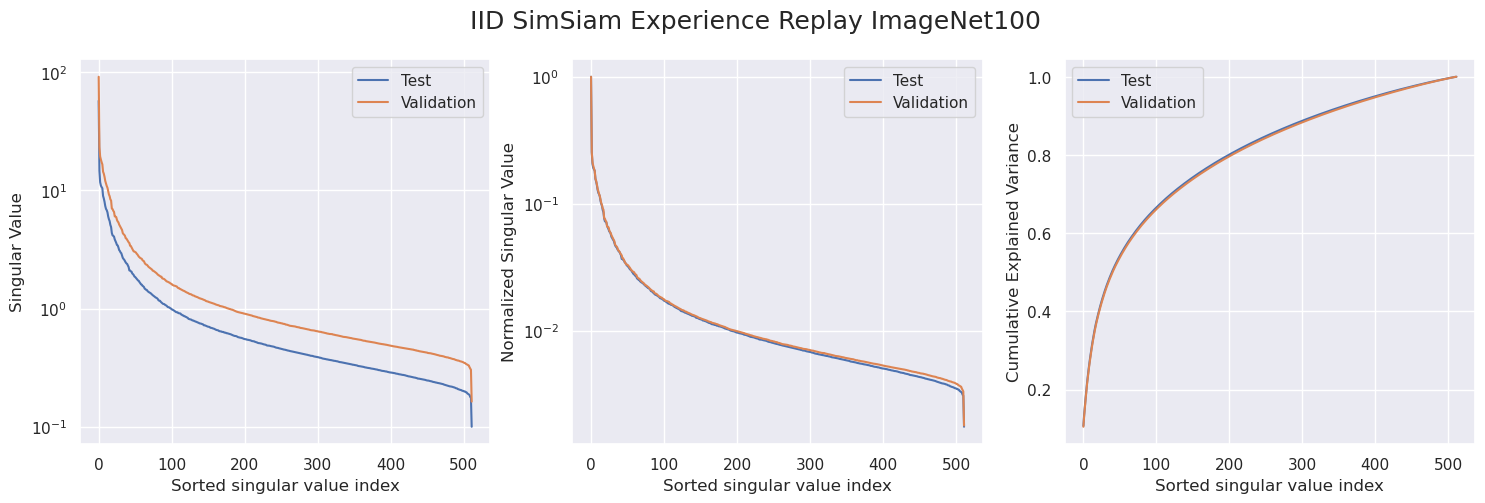

In [204]:
import os
plt.figure(figsize=(18, 5))
plt.suptitle(model_name, fontsize=18)

plt.subplot(1,3,1)
plt.plot(test_svd, label='Test')
plt.plot(val_svd, label='Validation')
plt.legend()
plt.xlabel("Sorted singular value index")
plt.ylabel('Singular Value')
plt.yscale('log')

plt.subplot(1,3,2)
plt.plot(test_svd/test_svd[0], label='Test')
plt.plot(val_svd/val_svd[0], label='Validation')
plt.legend()
plt.xlabel("Sorted singular value index")
plt.ylabel('Normalized Singular Value')
plt.yscale('log')

plt.subplot(1,3,3)
plt.plot(np.cumsum(test_svd) / test_svd.sum(), label='Test')
plt.plot(np.cumsum(val_svd) / val_svd.sum(),  label='Validation')
plt.legend()
plt.xlabel("Sorted singular value index")
plt.ylabel('Cumulative Explained Variance')

plt.savefig(os.path.join(model_pth, 'collapse_plots.png'), dpi=300)
plt.show()

AUC

In [205]:
def auc(singular_values):
    # Equation 2 from https://arxiv.org/abs/2209.15007
    explvar = np.cumsum(singular_values) / singular_values.sum()
    return explvar.sum() / len(explvar)

In [206]:
print('Test AUC:', auc(test_svd).item())
print('Validation AUC:', auc(val_svd).item())

Test AUC: 0.8010000586509705
Validation AUC: 0.7975839376449585


In [207]:
auc_save_file = os.path.join(model_pth, 'auc.txt')
with open(auc_save_file, 'w') as f:
    f.write(f'Val AUC: {auc(val_svd).item():.4f}\n') 
    f.write(f'Test AUC: { auc(test_svd).item():.4f}')

# Task aware collapse

In [208]:
num_exps = 20

Test svd

In [209]:
test_exps_svd_list = []

for exp_idx in range(num_exps):
    array = torch.from_numpy(np.load(os.path.join(activations_pth, f'test_activations_{exp_idx}.npy')))
    test_exps_svd_list.append(get_svd(array))

Validation svd

In [210]:
val_exps_svd_list = []

for exp_idx in range(num_exps):
    array = torch.from_numpy(np.load(os.path.join(activations_pth, f'test_activations_{exp_idx}.npy')))
    val_exps_svd_list.append(get_svd(array))

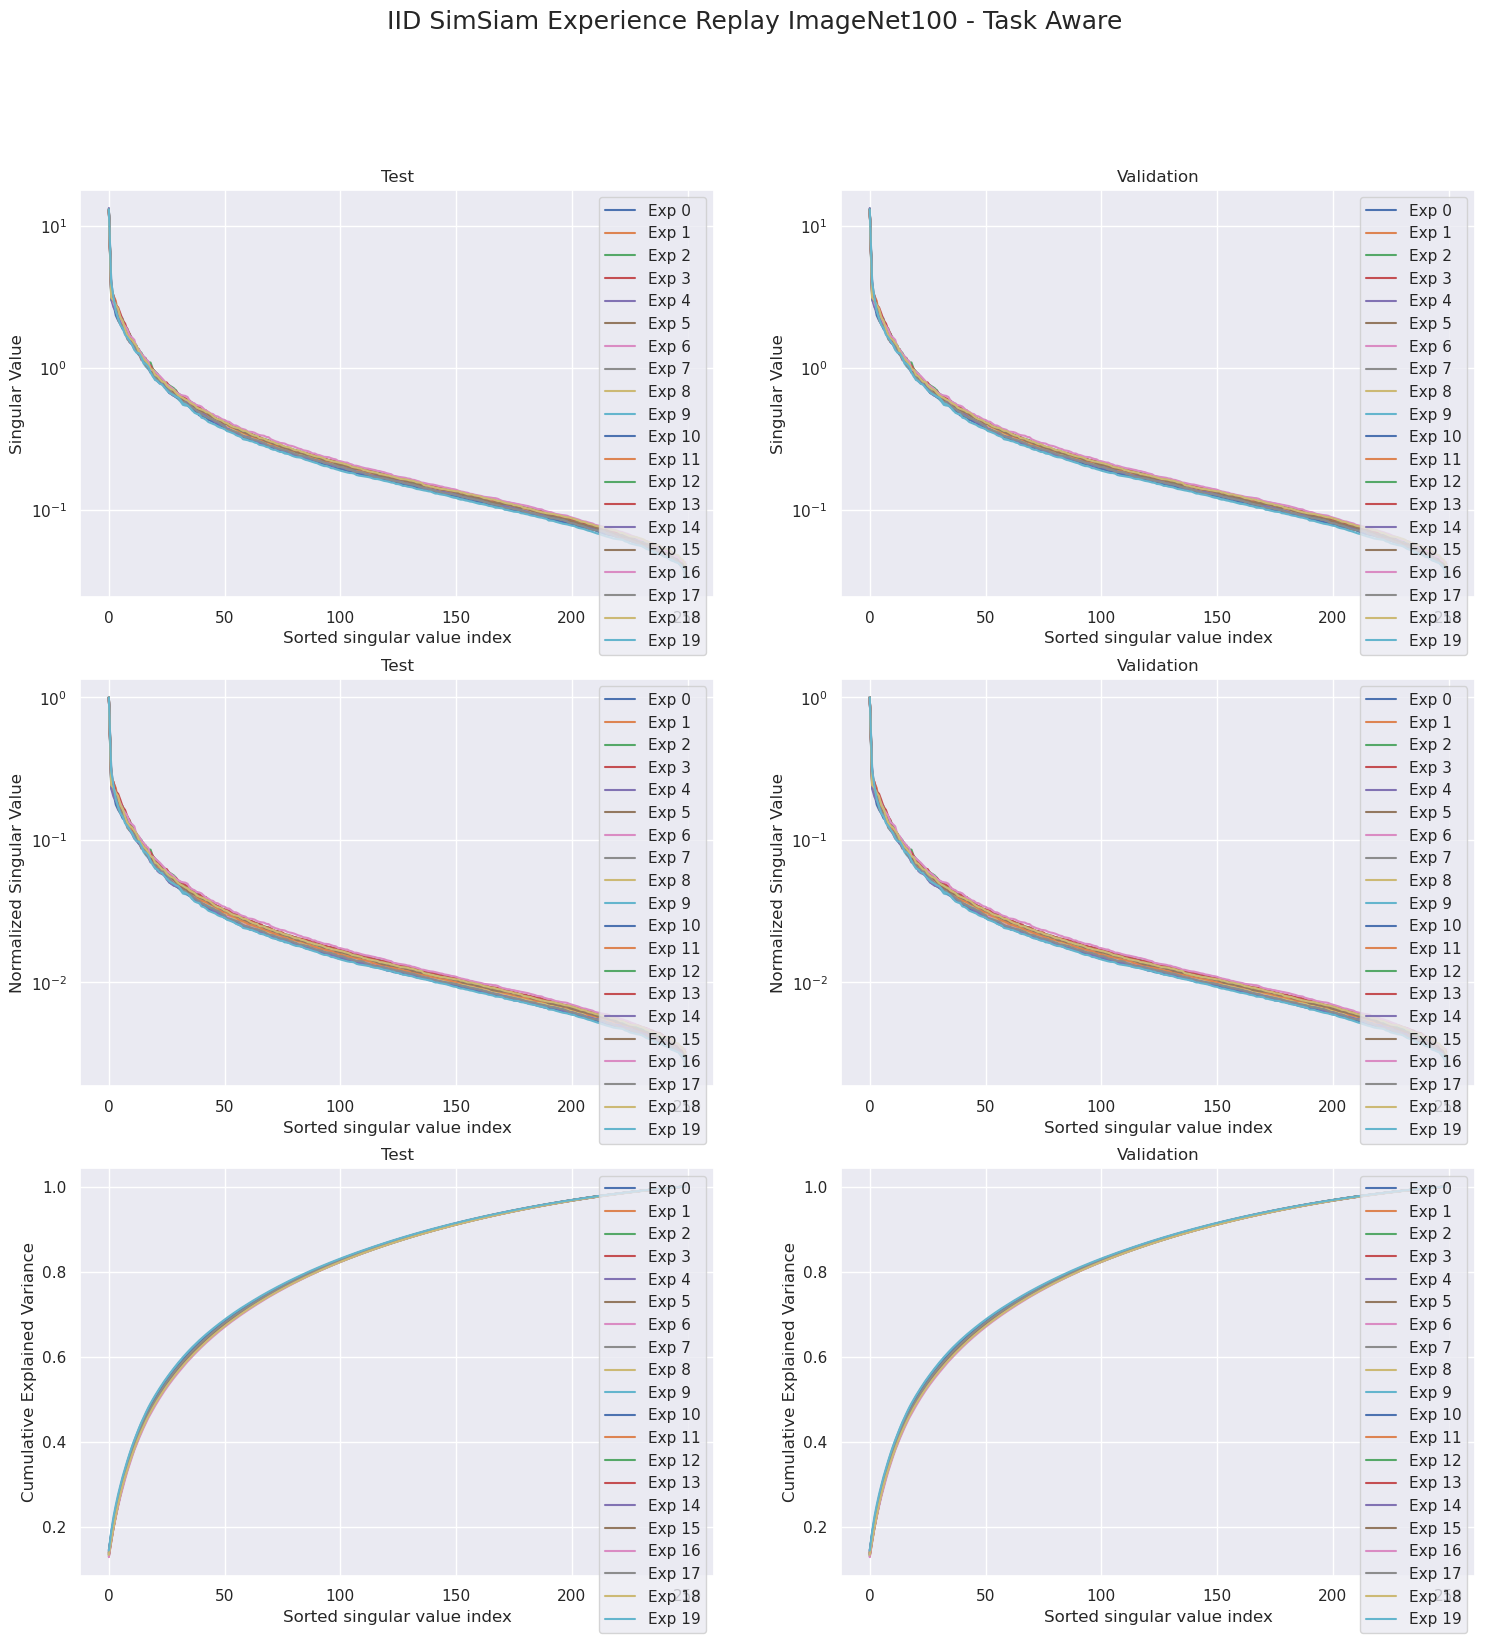

In [211]:
plt.figure(figsize=(18, 18))
plt.suptitle(f'{model_name} - Task Aware', fontsize=18)


plt.subplot(3,2,1)
for exp_idx, svd in enumerate (test_exps_svd_list):
    plt.plot(svd, label=f'Exp {exp_idx}')
plt.legend()
plt.xlabel("Sorted singular value index")
plt.ylabel('Singular Value')
plt.yscale('log')
plt.title('Test')

plt.subplot(3,2,2)
for exp_idx, svd in enumerate (val_exps_svd_list):
    plt.plot(svd, label=f'Exp {exp_idx}')
plt.legend()
plt.xlabel("Sorted singular value index")
plt.ylabel('Singular Value')
plt.yscale('log')
plt.title('Validation')

plt.subplot(3,2,3)
for exp_idx, svd in enumerate (test_exps_svd_list):
    plt.plot(svd/svd[0], label=f'Exp {exp_idx}')
plt.legend()
plt.xlabel("Sorted singular value index")
plt.ylabel('Normalized Singular Value')
plt.yscale('log')
plt.title('Test')

plt.subplot(3,2,4)
for exp_idx, svd in enumerate (val_exps_svd_list):
    plt.plot(svd/svd[0], label=f'Exp {exp_idx}')
plt.legend()
plt.xlabel("Sorted singular value index")
plt.ylabel('Normalized Singular Value')
plt.yscale('log')
plt.title('Validation')

plt.subplot(3,2,5)
for exp_idx, svd in enumerate (test_exps_svd_list):
    plt.plot(np.cumsum(svd) / svd.sum(), label=f'Exp {exp_idx}')
plt.legend()
plt.xlabel("Sorted singular value index")
plt.ylabel('Cumulative Explained Variance')
plt.title('Test')

plt.subplot(3,2,6)
for exp_idx, svd in enumerate (val_exps_svd_list):
    plt.plot(np.cumsum(svd) / svd.sum(), label=f'Exp {exp_idx}')
plt.legend()
plt.xlabel("Sorted singular value index")
plt.ylabel('Cumulative Explained Variance')
plt.title('Validation')

plt.savefig(os.path.join(model_pth, 'collapse_plots_task_aware.png'), dpi=300)
plt.show()